# Reconstruct 3-D shape from random Extended Gauss Image 
#### Nanfang Hong, Advanced Study Program

![1](Picture1.png)

# A convex 3-D object is one-to-one to **Extended Gauss Image (EGI)** up to translation

# Objective: find height $H$ (distance from origin to each surface)

### Define a type **ExtendedGaussImage**. 

In [2]:
using LinearAlgebra

In [3]:
struct ExtendedGaussImage 
    Normal::Array{Float64,2} where T <: Union{Int,Float64}
    Area::Union{Array{T,2},Array{T,1}} where T <: Union{Int,Float64}
    function ExtendedGaussImage((Normal, Area)) 
        if size(Normal)[2] != length(Area)
            error("Number of surface normal does not match number of surface area. ") 
        end
        if sum([norm(Normal[:,i]) for i in 1:length(Area)] - ones(length(Area))) > 1e-10
            error("Normal not unit vector")
        end
        if sum(Normal*Area) > 1e-10
            error("It is not a valid convex polyhedron (Does not satisfy sum of surfaces normal times area equals 0")
        end
        new(Normal,Area) 
    end
end

### Generate random extended gauss image

1. Generate a random matrix N with size(3, faces), then generally rank is 3. Note that to be a polyhedron the faces should at least 4, so the degree of freedom is (faces - 3). 
2. Generate a random vector v2 with length (faces - 3), then can determine v1 such that v = [v1 v2] and N*v = 0. 

In [4]:
function randEGI(faces::Int64)
    for i = 1:(10*faces)
        global Normed = zeros(3,1)
        for j = 1:faces  
            N = rand(3)*2 .-1
            N = N ./ norm(N)
            Normed = [Normed N]
        end
        global Normed = Normed[:,2:end]
        
        v2 = rand(faces - 3, 1)
        v1 = inv(Normed[:, 1:3])*(-Normed[:, 4:end]*v2)
        global v = [v1;v2]
        if (sum(v .> zeros(faces,1)) == faces)
            break
        end
    end
    return Normed,v
end

randEGI (generic function with 1 method)

### Example: Cube

In [ ]:
faces = 6
img = ExtendedGaussImage((Float64.([1 -1 0 0 0 0;
    0 0 1 -1 0 0;
    0 0 0 0 1 -1]),Float64.([1,1,1,1,1,1][:,:])))

### Example Tetrahedron

In [ ]:
faces = 4
img = ExtendedGaussImage((Float64.([1 0 0 -1;
    0 1 0 -1 ;
    0 0 1 -1 ]),Float64.([1/2,1/2,1/2,√3/2][:,:])))

# Little's Algorithm (original version)

#### Little's Algorithm (1985) provides an iterative scheme to reconstruct 3D shape from $EGI = (N, A)$, where $N$ is surface normal of each face and $A$ is area of each face

#### Let $H$ be distance from origin to each surface, then given $H$ and surface normal $N$, we can uniquely determine a corresponding polyhedron $P = P(H,N)$ by, 

1. Map the $n$ planes given by $H$ into $M$, a set of $n$ points in $R^3$, using the dual transform. 
Dual transform is defined as, given a plane $$Ax + By + Cz + 1 = 0$$, then corresponding dual point is $$(A, B, C)$$

2. Compute convex hull of $M$, which is also called the **dual of $P$** . Then any face of the dual of $P$ corresponds a vertex of $P$, any two points incident on an edge in the dual of $P$ correspond to a pair of faces of $P$ which share an edge. Then we know $P$ by its vertices and faces.



#### Little's Algorithm is: 
#### 1. Initial $H$ as 
$$[1,1,...,1]$$

#### 2. Compute $P$

#### 3. Compute $V(P)$ by area of faces $S = [S_1, S_2, ... ,S_n]$ using 
$$V(P) = \frac{1}{3}H^TS$$
#### gradient of V(P(H,N)) with respect to H is constant $$\nabla V(P) = \frac{1}{3}S$$ 
#### updating H by multiple of step $\Delta$, 
$$\Delta = \langle\,A,\nabla V(P)\rangle \nabla V(P) - A $$ 
which means just update $H$ proportional to $A$. Before update, scale $H$ by $V(P)^\frac{1}{3}=(\frac{1}{3}H^TS)^\frac{1}{3}$ to keep its volume unity

$$H \leftarrow(\frac{1}{3}H^TS)^\frac{1}{3}H - k\Delta$$

#### 4. repeat 2 and 3 until $|(H_{t+1} - H_{t})A|$ is less than $\epsilon$






In [5]:
using Polyhedra, QHull, Makie

In [6]:
function Surface(p::QHull.Polyhedron)
    S = Float64[]
    for pi in eachindex(halfspaces(p))
        global n = get(p, pi).a
        n = n/norm(n)
        get(p, pi).β
        global pts = incidentpoints(p, pi)
        global b = pts[2] - pts[1]
        b = b/norm(b)
        global a = cross(n, b) 
        norm(a)
        append!(S, Float64(Polyhedra.volume(polyhedron(vrep([[a b]'*pt for pt in pts]), QHull.Library()))))
    end
    return S
end

Surface (generic function with 1 method)

In [7]:
function Volume(H::Array{Float64,1}, S::Array{Float64,1}) 
    return 1/3*(H'*S)
end

function Volume(p::QHull.Polyhedron) 
    faces = length(hrep(p).b)
    H = MixedMatHRep(hrep(p)).b ./[norm(MixedMatHRep(hrep(p)).A[i,:]) for i in 1:faces]
    S = Float64[]
    for pi in eachindex(halfspaces(p))
        global n = get(p, pi).a
        n = n/norm(n)
        get(p, pi).β
        global pts = incidentpoints(p, pi)
        global b = pts[2] - pts[1]
        b = b/norm(b)
        global a = cross(n, b) 
        norm(a)
        append!(S, Float64(Polyhedra.volume(polyhedron(vrep([[a b]'*pt for pt in pts]), QHull.Library()))))
    end
    return 1/3*(H'*S)
end

Volume (generic function with 2 methods)

In [8]:
function Polyhedron(H,N)
    h = hrep(N', [norm(N[:,i]) for i in 1:length(H)] .* H)
    p = polyhedron(h, QHull.Library())
    return p
end

Polyhedron (generic function with 1 method)

In [9]:
function Normal(p::QHull.Polyhedron) 
    faces = length(hrep(p).b)
    return [MixedMatHRep(hrep(p)).A[i,:]./norm(MixedMatHRep(hrep(p)).A[i,:]) for i in 1:faces]
end

Normal (generic function with 1 method)

In [10]:
function randPolyhedron(faces)
    egi = randEGI(faces)
    img = ExtendedGaussImage(egi)
    for i in 1:(10*faces)
        H = rand(faces)
        global p = Polyhedron(H, img.Normal)
        if length(Surface(p)) == faces
            break
        end
    end
    return p, ExtendedGaussImage((img.Normal, Surface(p)[:,:]))
end

randPolyhedron (generic function with 1 method)

## Given a random valid EGI 

In [11]:
faces = 6#if faces = 4, it reconstruct immediately
p, img = randPolyhedron(faces)

(HalfSpace([-5.67972, -2.81342, 2.77206], 1.0) ∩ HalfSpace([-1.36039, 1.36022, 0.715521], 1.0) ∩ HalfSpace([-0.80731, 0.0541164, -0.847875], 1.0) ∩ HalfSpace([0.83325, 0.254902, 0.873617], 1.0) ∩ HalfSpace([0.0901262, -2.06049, -0.509373], 1.0) ∩ HalfSpace([0.949222, 0.733648, 0.645261], 1.0) : convexhull([-0.6361, 0.387788, -0.549001], [0.510115, 2.05235, -1.53414], [-0.416483, -0.305192, -0.802341], [3.48488, 0.766853, -4.44863], [0.108731, 0.35007, 0.938817], [0.134997, 0.396668, 0.900169], [0.54938, -0.662514, 0.813979], [1.43146, -0.396782, -0.104877]), ExtendedGaussImage([-0.821005 -0.662789 … 0.0424237 0.696824; -0.40668 0.66271 … -0.969903 0.538571; 0.400702 0.348606 … -0.239769 0.473686], [1.65763; 1.87756; … ; 6.06886; 9.02011]))

In [12]:
function RenderPolyhedron(p::QHull.Polyhedron)
    m = Polyhedra.Mesh(p)
    scene = mesh(m, color=:white)
end

RenderPolyhedron (generic function with 1 method)

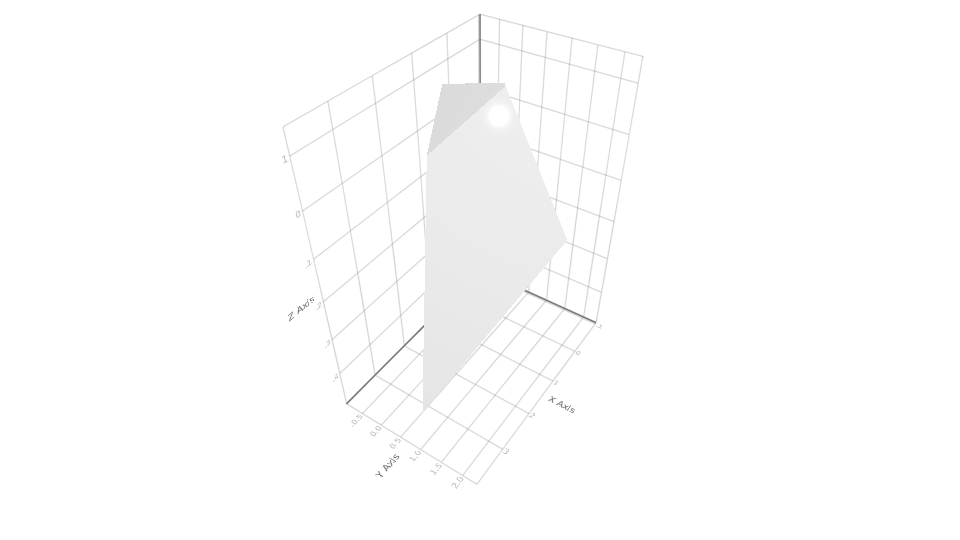

In [13]:
RenderPolyhedron(p)

## We now use Little's algorithm to recontruct $q$ from the EGI. We want $p = q$

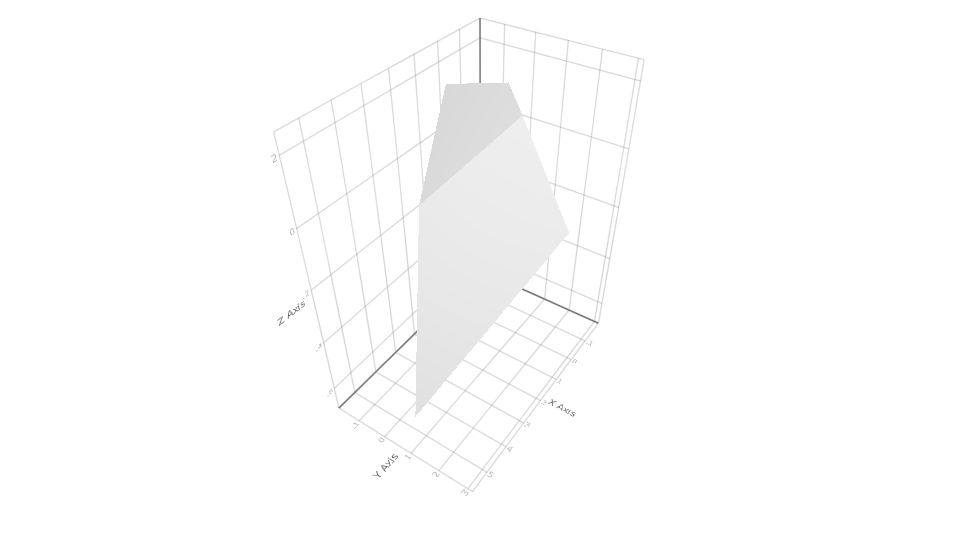

In [14]:
H = ones(faces)
q = Polyhedron(H, img.Normal)
RenderPolyhedron(q)

### $p$ and $q$ have same surface normal

In [17]:
Normal(q)

6-element Array{Array{Float64,1},1}:
 [-0.821005, -0.40668, 0.400702]  
 [-0.662789, 0.66271, 0.348606]   
 [-0.688835, 0.0461746, -0.723446]
 [0.675303, 0.206584, 0.708018]   
 [0.0424237, -0.969903, -0.239769]
 [0.696824, 0.538571, 0.473686]   

In [18]:
Normal(p)

6-element Array{Array{Float64,1},1}:
 [-0.821005, -0.40668, 0.400702]  
 [-0.662789, 0.66271, 0.348606]   
 [-0.688835, 0.0461746, -0.723446]
 [0.675303, 0.206584, 0.708018]   
 [0.0424237, -0.969903, -0.239769]
 [0.696824, 0.538571, 0.473686]   

# Little's Algorithm (slightly modified)

### Use KL divergence of proposed and true area distributions as error measure
### Modify iterative formula
--------------------------------------------------------

#### Given $EGI(N,A)$ of a convex polyhedron $p$ , want to construct polyhedron $q$ such that surface area distribution $P_A$ and $P_S$ are the same (KL divergence 0)
#### ($N$ is surface normal of $p$ and $q$, $A$ is surface area of $p$, $S$ is surface area of $q$. )
#### Initialize the $H$ (distance from origin to every surface) of $q$ all be 1, adjust $H$ such that KL divergence converges. 

#### 1. Initial $H$ as  $[1,1,...,1]$, $P_A \propto A$ 

#### 2. Compute $q$
#### 3. Scaling $H$ such that $V(q) = 1$, which means $H \leftarrow \frac{H}{V(q)^\frac{1}{3}}$
#### 4. Compute $q$ again. Compute $S$
#### 5. $\nabla V(q) = \frac{1}{3}S$
#### 6. $\Delta = \nabla V(q) - \frac{A}{\mid A \mid} {\mid V(q) \mid} $
#### 7. $H \leftarrow H + k\Delta$
#### 8. Scaling $H$ again, $H \leftarrow \frac{H}{V(q)^\frac{1}{3}}$
#### 9. Compute $q$ again. Compute $S$. $P_S  \propto S$
#### 10. Repeat 3-9 until $D(P_S \mid \mid P_A) < \epsilon$


In [ ]:
Surface(q)

In [15]:
Base.length(q::QHull.Polyhedron) = 1
Base.iterate(q::QHull.Polyhedron) = (q, nothing)
function Little(k, ϵ, img::ExtendedGaussImage)
    faces = length(img.Area)
    H = ones(faces)
    p1 = img.Area / sum(img.Area)
    KLArray = []
    KL = 0.05
    qArray = QHull.Polyhedron[]
    q = Polyhedron(H, img.Normal)
    while KL >= ϵ
        H = H / (Volume(q))^(1/3)
        q = Polyhedron(H, img.Normal)
        ∇ = 1/3*Surface(q)
        Δ = ∇ - (img.Area * norm(∇))/ norm(img.Area)
        H = vec(H + k .* Δ)
        H = H / (Volume(q))^(1/3)
        q = Polyhedron(H, img.Normal)
        p2 = Surface(q) / sum(Surface(q))
        KL = sum([p2[i]*log(p2[i]/p1[i]) for i in 1:faces])
        @show p2 ./ p1
        @show KL 
        append!(KLArray, KL)
        append!(qArray, q)
    end
    return qArray, KLArray
end

Little (generic function with 1 method)

In [16]:
k = 0.5
ϵ = 1e-11
qArray, KL = Little(k, ϵ, img)

p2 ./ p1 = [0.987372; 0.957916; 1.02358; 1.46553; 0.97987; 0.967926]
KL = 0.003188198216623906
p2 ./ p1 = [1.01082; 0.964599; 1.0121; 1.18764; 0.987789; 0.988877]
KL = 0.0006018150551309266
p2 ./ p1 = [1.01265; 0.974821; 1.00682; 1.08633; 0.992406; 0.995754]
KL = 0.00015202446296400563
p2 ./ p1 = [1.00971; 0.983443; 1.00398; 1.04349; 0.995314; 0.99824]
KL = 4.590537225336415e-5
p2 ./ p1 = [1.00657; 0.989534; 1.00236; 1.02336; 0.997134; 0.999209]
KL = 1.5208404262194745e-5
p2 ./ p1 = [1.00421; 0.993523; 1.00141; 1.0131; 0.998257; 0.999616]
KL = 5.268648872459891e-6
p2 ./ p1 = [1.00262; 0.996038; 1.00084; 1.00755; 0.998945; 0.999801]
KL = 1.8650043537053675e-6
p2 ./ p1 = [1.00161; 0.997593; 1.00051; 1.00443; 0.999363; 0.999891]
KL = 6.6735125859043e-7
p2 ./ p1 = [1.00098; 0.998543; 1.0003; 1.00263; 0.999615; 0.999939]
KL = 2.40152082429252e-7
p2 ./ p1 = [1.00059; 0.99912; 1.00018; 1.00157; 0.999768; 0.999964]
KL = 8.668663797134696e-8
p2 ./ p1 = [1.00036; 0.999469; 1.00011; 1.00094; 0.99

(QHull.Polyhedron[HalfSpace([-2.26988, -1.12437, 1.10785], 1.0) ∩ HalfSpace([-1.79709, 1.79688, 0.945215], 1.0) ∩ HalfSpace([-1.7014, 0.11405, -1.78689], 1.0) ∩ HalfSpace([1.55761, 0.476493, 1.63306], 1.0) ∩ HalfSpace([0.115461, -2.63971, -0.652562], 1.0) ∩ HalfSpace([2.09215, 1.61701, 1.4222], 1.0) : convexhull([-0.379201, -0.340947, -0.220333], [1.82248, 0.264046, -2.27806], [-0.512355, 0.0792071, -0.0667324], [0.121175, 0.999238, -0.611232], [0.134371, -0.530944, 0.639102], [0.743313, -0.347496, 0.00477013], [-0.12256, 0.0594681, 0.711892], [-0.0710295, 0.150892, 0.636066]), HalfSpace([-2.27377, -1.1263, 1.10974], 1.0) ∩ HalfSpace([-1.8145, 1.81428, 0.954369], 1.0) ∩ HalfSpace([-1.6536, 0.110846, -1.73668], 1.0) ∩ HalfSpace([1.49342, 0.456858, 1.56577], 1.0) ∩ HalfSpace([0.116399, -2.66114, -0.657859], 1.0) ∩ HalfSpace([2.15482, 1.66545, 1.4648], 1.0) : convexhull([-0.385711, -0.335796, -0.229985], [1.80763, 0.266905, -2.27992], [-0.516361, 0.0764591, -0.0792722], [0.117658, 0.9972,

In [19]:
typeof(qArray)

Array{QHull.Polyhedron,1}

In [ ]:
m = Polyhedra.Mesh(qArray[end])
scene = mesh(m, color=:white)

In [ ]:
using Plots
Plots.plot(1:length(KL), KL, label = "KL Divergence")

![5](BrunnMinkowski.png)

![6](Gradient.png)

## Animation of convergence by Makie.jl

![2](Animation.gif)

## Thought

In [ ]:
using Makie

for i in 1:length(qArray)
    @show i
    scene = Scene()
    m = Polyhedra.Mesh(qArray[i])
    mesh!(scene, m, color=:white)
    Makie.save(string(i)*".png", scene)
    sleep(1/24)
end

In [1]:
qArray

UndefVarError: UndefVarError: qArray not defined


### Try to use JuMP.jl but fail

$$\min_{H} HA $$
Subject to$$V(q) = 1$$

In [ ]:
using JuMP

In [ ]:
m = Model()
@variable(m, H[1:faces] >= 0)
@constraint(m,  Polyhedra.volume(polyhedron(hrep(img.Normal', [norm(img.Normal[:,i]) for i in 1:faces] .* H), QHull.Library())) == 1)
@objective(m, Min, H'*img.Area)
solve(m)